<a href="https://colab.research.google.com/github/canast07/EPL448-Ticket-price/blob/canast07/EPL448_Hybrid_Approach_w_Routes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
trainData = pd.read_excel("Data_Train.xlsx")
testData = pd.read_excel("Test_set.xlsx")
#sampData = pd.read_excel("Sample_submission.xlsx")

trainData.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [3]:
trainData.isnull().sum() # check for nulls

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [4]:
trainData.dropna(inplace=True) # Drop the rows that have null fields
print(trainData.isnull().sum())
trainData.dtypes # check the types

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64


Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Additional_Info    object
Price               int64
dtype: object

In [5]:
testData.isnull().sum() # check for nulls

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
dtype: int64

In [6]:
# trainData = trainData.drop(['Route'], axis = 1)
# trainData

In [7]:
# testData = testData.drop(['Route'], axis = 1)
testData

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info
...,...,...,...,...,...,...,...,...,...,...
2666,Air India,6/06/2019,Kolkata,Banglore,CCU → DEL → BLR,20:30,20:25 07 Jun,23h 55m,1 stop,No info
2667,IndiGo,27/03/2019,Kolkata,Banglore,CCU → BLR,14:20,16:55,2h 35m,non-stop,No info
2668,Jet Airways,6/03/2019,Delhi,Cochin,DEL → BOM → COK,21:50,04:25 07 Mar,6h 35m,1 stop,No info
2669,Air India,6/03/2019,Delhi,Cochin,DEL → BOM → COK,04:00,19:15,15h 15m,1 stop,No info


In [8]:
trainData['Additional_Info'] = trainData['Additional_Info'].replace({'No Info':'No info'})
trainData.Additional_Info.value_counts()

No info                         8347
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
1 Short layover                    1
2 Long layover                     1
Red-eye flight                     1
Name: Additional_Info, dtype: int64

In [9]:
train = trainData.copy()
test = testData.copy()
concatData = pd.concat(objs=[train,test],axis=0)

In [10]:
arr = np.empty((concatData['Duration'].count()))
concatData = concatData.reset_index(drop = True)
print(len(arr))
i = 0
for x in concatData['Duration']:
  # print("x", x)
  hours = 0
  minutes = 0
  if 'h' in str(x):
    tokens = str(x).split("h")
    hours = int(tokens[0]) * 60
    # print("hours = ", hours)
    if 'm' in str(x):
      temp = tokens[1].replace(' ', '').replace('m','')
      minutes = int(temp)
  else:
    temp = tokens[1].replace(' ', '').replace('m','')
    minutes = int(temp)
  time = hours + minutes
  arr[i] = time
  i += 1
  concatData['Duration'] = pd.Series(arr.astype(int))

13353


In [11]:
concatData['Arr_Time'] = concatData['Arrival_Time'].str.split(' ').str[0]
concatData = concatData.drop(['Arrival_Time'], axis = 1)
concatData.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Duration,Total_Stops,Additional_Info,Price,Arr_Time
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,170,non-stop,No info,3897.0,01:10
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,445,2 stops,No info,7662.0,13:15
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,1140,2 stops,No info,13882.0,04:25
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,325,1 stop,No info,6218.0,23:30
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,285,1 stop,No info,13302.0,21:35


In [12]:
concatData = pd.get_dummies(concatData, columns= ['Additional_Info'],drop_first=True)
concatData = pd.get_dummies(concatData, columns= ['Airline'],drop_first=True)
# concatData = pd.get_dummies(concatData, columns= ['Total_Stops'],drop_first=True)
# concatData = pd.get_dummies(concatData, columns= ['Source'],drop_first=True)
# concatData = pd.get_dummies(concatData, columns= ['Destination'],drop_first=True)
concatData = pd.get_dummies(concatData, columns= ['Dep_Time'],drop_first=True)
concatData = pd.get_dummies(concatData, columns= ['Arr_Time'],drop_first=True)
concatData = pd.get_dummies(concatData, columns= ['Date_of_Journey'],drop_first=True)

In [13]:
concatData['Total_Stops'] = concatData['Total_Stops'].astype('category')
concatData['Total_Stops'] = concatData['Total_Stops'].cat.codes

In [14]:
concatData['Source'] = concatData['Source'].astype('category')
concatData['Source'] = concatData['Source'].cat.codes

In [15]:
concatData['Destination'] = concatData['Destination'].astype('category')
concatData['Destination'] = concatData['Destination'].cat.codes

In [16]:
concatData = pd.get_dummies(concatData, columns= ['Route'],drop_first=True)

In [17]:
concatData

,Source,Destination,Duration,Total_Stops,Price,Additional_Info_1 Short layover,Additional_Info_2 Long layover,Additional_Info_Business class,Additional_Info_Change airports,Additional_Info_In-flight meal not included,Additional_Info_No check-in baggage included,Additional_Info_No info,Additional_Info_Red-eye flight,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Dep_Time_00:25,Dep_Time_00:30,Dep_Time_00:40,Dep_Time_01:30,Dep_Time_01:35,Dep_Time_01:40,Dep_Time_02:00,Dep_Time_02:05,Dep_Time_02:15,Dep_Time_02:30,Dep_Time_02:35,Dep_Time_02:55,Dep_Time_03:00,Dep_Time_03:05,Dep_Time_03:50,Dep_Time_04:00,...,Route_CCU → JAI → DEL → BLR,Route_CCU → KNU → BLR,Route_CCU → MAA → BLR,Route_CCU → NAG → BLR,Route_CCU → PAT → BLR,Route_CCU → PNQ → BLR,Route_CCU → RPR → HYD → BLR,Route_CCU → VNS → DEL → BLR,Route_CCU → VTZ → BLR,Route_DEL → AMD → BOM → COK,Route_DEL → AMD → COK,Route_DEL → ATQ → BOM → COK,Route_DEL → BBI → COK,Route_DEL → BDQ → BOM → COK,Route_DEL → BHO → BOM → COK,Route_DEL → BLR → COK,Route_DEL → BOM → COK,Route_DEL → CCU → BOM → COK,Route_DEL → COK,Route_DEL → DED → BOM → COK,Route_DEL → GOI → BOM → COK,Route_DEL → GWL → IDR → BOM → COK,Route_DEL → HYD → BOM → COK,Route_DEL → HYD → COK,Route_DEL → HYD → MAA → COK,Route_DEL → IDR → BOM → COK,Route_DEL → IXC → BOM → COK,Route_DEL → IXU → BOM → COK,Route_DEL → JAI → BOM → COK,Route_DEL → JDH → BOM → COK,Route_DEL → LKO → BOM → COK,Route_DEL → LKO → COK,Route_DEL → MAA → BOM → COK,Route_DEL → MAA → COK,Route_DEL → NAG → BOM → COK,Route_DEL → PNQ → COK,Route_DEL → RPR → NAG → BOM → COK,Route_DEL → TRV → COK,Route_DEL → UDR → BOM → COK,Route_MAA → CCU
0,0,5,170,4,3897.0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3,0,445,1,7662.0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,1,1140,1,13882.0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,3,0,325,0,6218.0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,5,285,0,13302.0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13348,3,0,1435,0,NaN,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13349,3,0,155,4,NaN,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13350,2,1,395,0,NaN,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13351,2,1,915,0,NaN,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
train_size = len(train)
train = concatData[:train_size]
test = concatData[train_size:]
test = test.drop(['Price'], axis = 1)

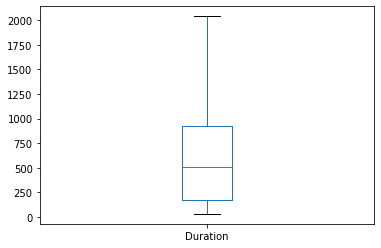

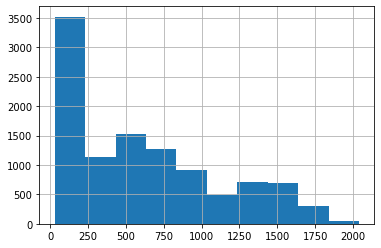

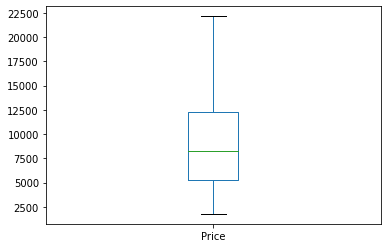

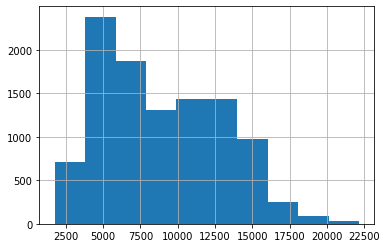

In [19]:
# Remove outliers of Duration
median = np.percentile(train.Duration,50)  # median
std = train.Duration.std() # standard deviation 
train = train.drop(train[ train.Duration > (median+3*std)].index) # drop "outliers " that are > median + 3*std
train['Duration'].plot(kind='box', subplots=True)
plt.show()
train['Duration'].hist()
plt.show()

# Remove price outliers
median = np.percentile(train.Price,50)  # median
std = train.Price.std() # standard deviation 
train = train.drop(train[ train.Price > (median+3*std)].index) # drop "outliers " that are > median + 3*std
train['Price'].plot(kind='box', subplots=True)
plt.show()
train['Price'].hist()
plt.show()

In [20]:
plt.figure(figsize=(40,40))
sns.heatmap(train.corr(), annot=True, cmap='RdYlGn')

Error in callback <function flush_figures at 0x7f6134afc290> (for post_execute):


KeyboardInterrupt: ignored

In [21]:
x = train.drop(['Price'], axis = 1)
y = train.Price.values

In [22]:
from sklearn.pipeline import Pipeline
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledDT', Pipeline([('Scaler', StandardScaler()),('DT', DecisionTreeRegressor())])))
pipelines.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
pipelines.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF',RandomForestRegressor())])))
pipelines.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()),('SVR',SVR())])))
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=21)
    cv_results = cross_val_score(model, x, y, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name,-cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: 601829523903545867115486813093888.000000 (1023536264058051393972297818701824.000000)
ScaledLASSO: 1985220.745964 (104830.434955)
ScaledEN: 3143374.713082 (193710.111939)
ScaledKNN: 3720878.820669 (238505.713828)
ScaledDT: 1744096.269374 (259430.107495)
ScaledGBM: 2812541.016160 (128267.784495)
ScaledRF: 1215429.972978 (120755.174060)


KeyboardInterrupt: ignored

## **Random Forest Regression**

In [23]:
scaler = StandardScaler().fit(x)
rescaled_X_train = scaler.transform(x)
model = RandomForestRegressor()
model.fit(rescaled_X_train, y)

scaler = StandardScaler().fit(test)
rescaled_X_test = scaler.transform(test)
predictions = model.predict(rescaled_X_test)

df_dt = pd.DataFrame(predictions.astype(int))
df_dt.columns=['Price']
filepath_dt = 'Predictions_RandomForest_5th_Hybrid.xlsx'
df_dt.to_excel(filepath_dt, index=False)
df_dt.head()

,Price
0,14714
1,4432
2,12898
3,13009
4,3884


## **Gradient Boosting Regression**

In [ ]:
scaler = StandardScaler().fit(x)
rescaled_X_train = scaler.transform(x)
model = GradientBoostingRegressor()
model.fit(rescaled_X_train, y)

scaler = StandardScaler().fit(test)
rescaled_X_test = scaler.transform(test)
predictions = model.predict(rescaled_X_test)

df_dt = pd.DataFrame(predictions.astype(int))
df_dt.columns=['Price']
filepath_dt = 'Predictions_GradientBoosting_5th_Hybrid.xlsx'
df_dt.to_excel(filepath_dt, index=False)
df_dt.head()

## **Decision Tree Regression**

In [ ]:
scaler = StandardScaler().fit(x)
rescaled_X_train = scaler.transform(x)
model = DecisionTreeRegressor()
model.fit(rescaled_X_train, y)

scaler = StandardScaler().fit(test)
rescaled_X_test = scaler.transform(test)
predictions = model.predict(rescaled_X_test)

df_dt = pd.DataFrame(predictions.astype(int))
df_dt.columns=['Price']
filepath_dt = 'Predictions_DecisionTree_4th_5th_Hybrid.xlsx'
df_dt.to_excel(filepath_dt, index=False)
df_dt.head()

## **KNeighborsRegressor**

In [ ]:
scaler = StandardScaler().fit(x)
rescaled_X_train = scaler.transform(x)
model = KNeighborsRegressor()
model.fit(rescaled_X_train, y)

scaler = StandardScaler().fit(test)
rescaled_X_test = scaler.transform(test)
predictions = model.predict(rescaled_X_test)

df_dt = pd.DataFrame(predictions.astype(int))
df_dt.columns=['Price']
filepath_dt = 'Predictions_KNeighbors_5th_Hybrid.xlsx'
df_dt.to_excel(filepath_dt, index=False)
df_dt.head()